# Sentiment classifier with LSTM

In this notebook, we will implement a simple sentiment classifier using an LSTM. Follow the notebook, complete the missing part, answer the questions and apply the asked modifications.



In [1]:
%pip install datasets

Note: you may need to restart the kernel to use updated packages.


In [2]:
from collections import defaultdict
from copy import deepcopy
import re
from typing import Callable, List, Tuple

from datasets import load_dataset
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch import nn
import torch.nn.functional as F
from tqdm.auto import tqdm
from datetime import datetime
from sklearn.utils import shuffle

## Downloading the dataset

Using the datasets library, we load the imdb dataset.

In [3]:
dataset = load_dataset("imdb")

Found cached dataset imdb (C:/Users/Alex POIRON/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1)


  0%|          | 0/3 [00:00<?, ?it/s]

In [4]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

In [5]:
# We do not need the "unsupervised" split.
dataset.pop("unsupervised")

Dataset({
    features: ['text', 'label'],
    num_rows: 50000
})

In [6]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
})

In [7]:
dataset["train"][:2]

{'text': ['I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far b

## Pretreatment **(1 point)**

Code the `pretreatment` function which clean the input text. Look at the dataset and deduce which treatment is needed.

In [8]:
import string 

def pretreatment(text: str) -> str:
    """Clean IMDB text entries.
    Args:
        text: an input string.
    Returns:
        The cleaned text.
    """
    # Your code here
    return text.translate(str.maketrans('', '', string.punctuation)).lower() 

In [9]:
# This applies the pretreatment function to all
clean_dataset = dataset.map(lambda x: {"text": pretreatment(x["text"]), "label": x["label"]})

Loading cached processed dataset at C:/Users/Alex POIRON/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1\cache-52f0bd0b765074b1.arrow
Loading cached processed dataset at C:/Users/Alex POIRON/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1\cache-19871201068f25d1.arrow


Let's see what the text now look like.

In [10]:
clean_dataset["train"]["text"][:3]

['i rented i am curiousyellow from my video store because of all the controversy that surrounded it when it was first released in 1967 i also heard that at first it was seized by us customs if it ever tried to enter this country therefore being a fan of films considered controversial i really had to see this for myselfbr br the plot is centered around a young swedish drama student named lena who wants to learn everything she can about life in particular she wants to focus her attentions to making some sort of documentary on what the average swede thought about certain political issues such as the vietnam war and race issues in the united states in between asking politicians and ordinary denizens of stockholm about their opinions on politics she has sex with her drama teacher classmates and married menbr br what kills me about i am curiousyellow is that 40 years ago this was considered pornographic really the sex and nudity scenes are few and far between even then its not shot like some

Let's take a quick look at the labels. Notice that the labels are ordered in the training set starting by the negative reviews (0), followed by the positive ones (1). Training neural networks on this kind of configuration tends to considerably affect their performances. So the dataset will have to be shuffled.

In [11]:
clean_dataset["train"]["label"][12490:12510]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

## Train/validation split **(1 point)**

In our example, we consider the test split as production data. Which means, we need to treat it as if we never see it during the training process. To experiment on the model, we need to split the training set into a training and validation set. See [here](https://huggingface.co/course/chapter5/3?fw=pt#creating-a-validation-set) on how to do so with the `Datasets` library.

Don't forget to **stratify** your split (we need to have the same proportion of class in both training and validation set).

In [12]:
clean_dataset = clean_dataset['train'].train_test_split(train_size=0.80, stratify_by_column='label')
clean_dataset['validation'] = clean_dataset.pop('test')
clean_dataset['test'] = dataset['test']

In [13]:
clean_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 20000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 5000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
})

In [14]:
print("Number of 0 in train:", clean_dataset['train']['label'].count(0))
print("Number of 1 in train:", clean_dataset['train']['label'].count(1))
print("Number of 0 in validation:", clean_dataset['validation']['label'].count(0))
print("Number of 1 in validation:", clean_dataset['validation']['label'].count(1))

Number of 0 in train: 10000
Number of 1 in train: 10000
Number of 0 in validation: 2500
Number of 1 in validation: 2500


## Categorical encoding of the vocabulary **(2 points)**

We can't feed word to a neural network. A usual solution is to turn words into categorical data by using one-hot encoding. To avoid an explosion in vocabulary size, we will only keep words which appear more than a certain amount of time.

The `Vocabulary` class below will do that for us.

In [15]:
UNK_TOKEN = "<UNK>"
PAD_TOKEN = "<PAD>"


class Vocabulary:
    """Vocabulary manager on a collection.
    """
    def __init__(self) -> None:
        """No parameters to provide.
        """
        # Index to word mapping.
        self.index2word = [PAD_TOKEN, UNK_TOKEN]
        # Word to index mapping.
        self.word2index = {value: key for key, value in enumerate(self.index2word)}
        # Word counter.
        self.word2count = defaultdict(int)

    def add_word(self, word: str) -> None:
        """Increments the count of a word to the vocabulary.
        Args:
            word: the word.
        """
        self.word2count[word] += 1
        if not word in self.word2index:
            self.word2index[word] = len(self.index2word)
            self.index2word.append(word)

    def add_text(self, text: str, separator: str =" ") -> None:
        """Add the words given in a text to our vocabulary.
        Args:
            text: a sequence of words separated by a given separator.
            separator: the separator used to split our text (default is " ").
        """
        for word in text.split(separator):
            self.add_word(word)

    def get_index(self, word: str) -> int:
        """Returns the index of a given word in our vocabulary.
        If the word is not in the vocabulary, returns the index for UNK_TOKEN.
        Args:
            word: a string.
        Returns:
            The corresponding index or the index for UNK_TOKEN.
        """
        return (
            self.word2index[word]
            if word in self.word2index
            else self.word2index[UNK_TOKEN]
        )

    def get_word(self, index: int) -> str:
        """Returns the word at a given index in our vocabulary.
        Args:
            index: the word position in our vocabulary.
        Returns:
            The word corresponding to the given index.
        """
        return self.index2word[index]

    def get_word_count(self, word: str) -> int:
        """Returns the number of occurences for a given word.
        Raise a 
        Args:
            The word.
        Returns:
            Its number of measured occurences.
        """
        return self.word2count[word]

    def get_vocabulary(self) -> List[str]:
        """Returns a copy of the whole vocabulary list.
        Returns:
            A list of words.
        """
        return deepcopy(self.index2word)

    def __len__(self) -> int:
        """len() function.
        Returns:
            The number of words in the vocabulary.
        """
        return len(self.index2word)

    def trim_vocabulary(self, min_occurences: int = 5) -> None:
        """Trim the vocabulary based on the number of occurrences of each words.
        Note that whole counts of deleted words are added to the UNK_TOKEN counts.
        Args:
            min_occurences: the minimum number of occurences for a word to be kept.
        """
        to_delete = {
            word for word, count in self.word2count.items() if count < min_occurences
        }
        new_word2count = defaultdict(int)
        for word, count in self.word2count.items():
            if word not in to_delete:
                new_word2count[word] = count
            else:
                new_word2count[UNK_TOKEN] += count
        new_index2word = [word for word in self.index2word if word not in to_delete]
        new_word2index = {word: index for index, word in enumerate(new_index2word)}

        self.word2count = new_word2count
        self.index2word = new_index2word
        self.word2index = new_word2index

**(1 point)** Get the vocabulary on both the training and validation set using the `Vocabulary` class. Remember, we don't use the test set here as we consider it as proxy production data. The trim it down as you see fit (around 20K words in the vocabulary is a good value).

In [16]:
import datasets 
vocabulary = Vocabulary()

def add_vocabulary(ds: datasets.dataset_dict.DatasetDict) -> None:
    """From a dataset, add text in a vocabulary object
    Args:
        ds: the dataset
    """
    for  text in ds['text']:
        vocabulary.add_text(text)

#Add in the Vocabulary object vocabulary text from train and validation datasets
add_vocabulary(clean_dataset['train'])
add_vocabulary(clean_dataset['validation'])

#Trim the vocabulary with 10 occurences to have around 20k values
vocabulary.trim_vocabulary(10)

voc = vocabulary.get_vocabulary()

print("Vocabulary's length:", len(voc), "words")

Vocabulary's length: 21184 words


**(1 point)** Fill the encoding and decoding functions. The encoding function takes a text as input and returns a list IDs corresponding to the index of each word in the vocabulary. The decoding function reverse the process, turning a list of IDs into a text. Make sure the encoding function returns a numpy array.

In [17]:
# Encoding and decoding function

def encode_text(text: str) -> np.ndarray:
    """Encoding function
    Args:
        text (str): the text we want to encode
    Returns:
        np.ndarray: indexes corresponding to the text
    """
    indexes = []
    words = text.split()
    for word in words:
        indexes.append(vocabulary.get_index(word))
    
    #Return a ndarray
    return np.array(np.array(indexes))

def decode_text(encoded_text: np.ndarray) -> str:
    """Decoding function
    Args:
        encoded_text (np.ndarray): indexes numpy array
    Returns:
        str: a decoded text from indexes
    """
    words = []
    for index in encoded_text:
        words.append(vocabulary.get_word(index))
    
    final_str = " ".join(words) 
    return final_str

To make sure everything went well, we compare a text before and after encoding and then decoding it. You should see rare words / typos replaced by the `<UNK>` token.

In [18]:
# Apply the encoding function to the entire dataset.
encoded_dataset = clean_dataset.map(lambda x: {"text": encode_text(x["text"]), "label": x["label"]})

  0%|          | 0/20000 [00:00<?, ?ex/s]

  0%|          | 0/5000 [00:00<?, ?ex/s]

  0%|          | 0/25000 [00:00<?, ?ex/s]

In [19]:
clean_dataset["train"]["text"][0], decode_text(encoded_dataset["train"]["text"][0])

('this is an entertaining movie actually might make you uncomfortable since it isnt some undead psychopath or sociopath its your everyday doctor how scary is that got some good actors and actresses in this movie though some where unappreciated like virginya keehne as sarah ken foree who you might recognize from rob zombies devils rejects and halloween2007 costars as our detective on schizoid dr alan feinstonescorbin bensontrail short little summary is this dr alan feinstone a guy who has a sexy wife nice house and is a great dentist everyone loves until he catches his wife cheating on him with the pool cleaner then he starts having hallucinations that his patients teeth are all rotted and that the female patients are his wife as he starts going nuts in this thriller but before that nice guy',
 'this is an entertaining movie actually might make you uncomfortable since it isnt some undead psychopath or sociopath its your everyday doctor how scary is that got some good actors and actresse

## Batch preparation **(1 point)**

To speed up learning, and take advantage of the GPU architecture, we provide data to the model by batches. Since all line in the same batch need to have the same length, we pad lines to the maximum length of each batch.

In [20]:
def data_generator(X: np.ndarray, y: np.ndarray, batch_size: int = 32, pad_right: bool = False) -> Tuple[np.ndarray, np.ndarray]:
    """Generate randomly ordered batches of data+labels.
    Args:
        X: the input data.
        y: the corresponding labels.
        batch_size: the size of each batch [32].
        pad_right: if true, the padding is done on the right [False].
    """
    
    X, y = shuffle(X, y)
    n_batches = int(np.ceil(len(y) / batch_size))
    
    for i in range(n_batches):
        
        end = min((i+1)*batch_size, len(y))
        
        X_batch = X[i*batch_size:end]
        y_batch = y[i*batch_size:end]

        # Padding to max ength size within the batch
        max_len = np.max([len(x) for x in X_batch])
        for j in range(len(X_batch)):
            x = X_batch[j]
            pad = [vocabulary.get_index(PAD_TOKEN)] * (max_len - len(x))
            X_batch[j] = x+pad if pad_right else pad+x

        X_batch = torch.from_numpy(np.array(X_batch)).long()
        y_batch = torch.from_numpy(np.array(y_batch)).long()

        # Yielding results, so every time the function is called, it starts again from here.
        yield X_batch, y_batch

Let's see what the batches look like.

In [21]:
for inputs, labels in data_generator(encoded_dataset["train"]["text"], encoded_dataset["train"]["label"]):
    print("inputs", inputs, "shape:", inputs.shape)
    print("labels", labels, "shape:", labels.shape)
    break

inputs tensor([[    0,     0,     0,  ...,   224,    13,   619],
        [    0,     0,     0,  ...,    75,   257,    95],
        [    0,     0,     0,  ...,  1656,    13,  7704],
        ...,
        [    0,     0,     0,  ...,  3244, 19235,  1812],
        [    0,     0,     0,  ...,    75,   949,  9740],
        [    0,     0,     0,  ...,  2355,    98,    13]]) shape: torch.Size([32, 898])
labels tensor([0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 1, 0, 1, 0]) shape: torch.Size([32])


**(1 point)** Question: On which side should we pad the data for our use case and why?

## The model **(13 points)**

We use a simple RNN with a configurable number of layers.

In [22]:
# Before starting, let's set up the device. A GPU if available, else the CPU.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [23]:
class RNN(nn.Module):
    """A simple RNN module with word embeddings.
    """
    def __init__(self, vocab_size: int, embed_size: int, hidden_size: int, n_layers: int, n_outputs: int) -> None:
        """
        Args:
            vocab_size: vocabulary size.
            embed_size: embedding dimensions.
            hidden_size: hidden layer size.
            n_layers: the number of layers.
            n_outputs: the number of output classes.
        """
        super().__init__()
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.n_outputs = n_outputs


        # The word embedding layer.
        self.embed = nn.Embedding(self.vocab_size, self.embed_size)
        # The RNN
        self.rnn = nn.RNN(
            input_size = self.embed_size,
            hidden_size = self.hidden_size,
            num_layers = self.n_layers,
            batch_first = True, # Changes the order of dimension to put the batches first.
        )
        # A fully connected layer to project the RNN's output to only one output used for classification.
        self.fc = nn.Linear(self.hidden_size, self.n_outputs)

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        """Function called when the model is called with data as input.
        Args:
            X: the input tensor of dimensions batch_size, sequence length, vocab size (actually just an int).
        Returns:
            The resulting tensor of dimension batch_size, sequence length, output dimensions.
        """
        h0 = torch.zeros(self.n_layers, X.size(0), self.hidden_size).to(device)

        out = self.embed(X)
        # out contains the output layer of all words in the sequence.
        # First dim is batch, second the word in the sequence, third is the vector itself.
        # The second output value is the last vector of all intermediate layer.
        # Only use it if you want to access the intermediate layer values of a
        # multilayer model.
        out, _ = self.rnn(out, h0)
        # Getting the last value only.
        out = out[:, -1, :]
    
        # Linear projection.
        out = self.fc(out)

        return out

Note that we do not pass the output through a sigmoid function. This is because pyTorch implements some code optimization within the `BCEWithLogitsLoss` we'll see later.

In [24]:
def train(
    model: nn.Module,
    criterion: Callable,
    optimizier: torch.optim.Optimizer,
    n_epochs: int,
    train_gen: Callable,
    valid_gen: Callable,
) -> Tuple[List[float], List[float]]:
    """Train a model using a batch gradient descent.
    Args:
        model: a class inheriting from nn.Module.
        criterion: a loss criterion.
        optimizer: an optimizer (e.g. Adam, RMSprop, ...).
        n_epochs: the number of training epochs.
        train_gen: a callable function returing a batch (data, labels).
        valid_gen: a callable function returing a batch (data, labels).
    """
    train_losses = np.zeros(n_epochs)
    valid_losses = np.zeros(n_epochs)

    for epoch in range(n_epochs):

        t0 = datetime.now()
        model.train()
        train_loss = []

        # Training loop.
        for inputs, labels in train_gen():
            # labels are of dimension (N,) we turn them into (N, 1).
            labels = labels.view(-1, 1).float()
            # Put them on the GPU.
            inputs, labels = inputs.to(device), labels.to(device)

            # Reset the gradient.
            optimizier.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizier.step()

            train_loss.append(loss.item())  # .item() detach the value from GPU.

        train_losses[epoch] = np.mean(train_loss)

        model.eval()
        valid_loss = []
        # Evaluation loop.
        for inputs, labels in valid_gen():
            labels = labels.view(-1, 1).float()
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            valid_loss.append(loss.item())

        valid_losses[epoch] = np.mean(valid_loss)

        print(f"Epoch: {epoch}, training loss: {train_losses[epoch]}, validation loss: {valid_losses[epoch]}, in {datetime.now() - t0}")

    return train_losses, valid_losses, model

We setup the model, criterion (a binary cross entropy), and the optimizer (Adam).

Note that `BCEWithLogitsLoss` use a mathematical trick to incorporate the sigmoid function in its computation. This trick makes the learning process go slightly faster and is the reason why we didn't put a sigmoid in the forward function of the model.

In [25]:
model = RNN(len(vocabulary), 32, 64, 1, 1).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters())

We get the 3 generators.

In [26]:
train_gen = lambda: data_generator(encoded_dataset["train"]["text"], encoded_dataset["train"]["label"])
valid_gen = lambda: data_generator(encoded_dataset["validation"]["text"], encoded_dataset["validation"]["label"])
test_gen = lambda: data_generator(encoded_dataset["test"]["text"], encoded_dataset["test"]["label"])

And train the model.

In [56]:
train_losses, valid_losses, model = train(model, criterion, optimizer, 10, train_gen, valid_gen)

Epoch: 0, training loss: 0.48463331305980684, validation loss: 0.5857046876743341, in 0:02:37.283518
Epoch: 1, training loss: 0.4425043787479401, validation loss: 0.5285474982610934, in 0:02:46.101489
Epoch: 2, training loss: 0.43772379553318025, validation loss: 0.5483189094218479, in 0:03:00.511547
Epoch: 3, training loss: 0.3799526152610779, validation loss: 0.5419846078392806, in 0:02:37.667701
Epoch: 4, training loss: 0.36108479948043826, validation loss: 0.5533321042349384, in 0:02:45.683001
Epoch: 5, training loss: 0.35944605664014817, validation loss: 0.534532787693534, in 0:03:00.932683
Epoch: 6, training loss: 0.43428791162967684, validation loss: 0.624692848343758, in 0:02:49.503754
Epoch: 7, training loss: 0.4291174755096436, validation loss: 0.5741557976242843, in 0:03:03.422236
Epoch: 8, training loss: 0.312153040933609, validation loss: 0.5753983020023176, in 0:02:54.229004
Epoch: 9, training loss: 0.2896243368268013, validation loss: 0.5798724611663515, in 0:03:03.53280

We can look at the training and validation loss.

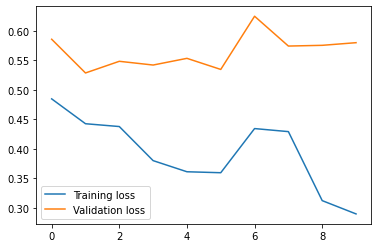

In [57]:
plt.plot(train_losses, label="Training loss")
plt.plot(valid_losses, label="Validation loss")
plt.legend()

For the assignment, code the following.
* **(2 points)** The model validation loss should go down and then up. It means the model starts overfitting after a certain number of iterations. Modify the `train` function so it returns the model found with the best validation loss.
* **(2 points)** Add an accuracy function and report the accuracy of the training and test set.
* **(3 points)** Create an LSTM class which uses an LSTM instead of an RNN. Compare its results with the RNN.
* **(2 point)** Implement a function which takes any text and return the model's prediction.
    * The function should have a string as input and return a class (0 or 1) and its probability (score out of a [sigmoid](https://pytorch.org/docs/stable/generated/torch.sigmoid.html)).
    * Don't forget to make the text go through the same pretreatment and encoding you used to train your model.
* **(3 points)** Create a bidirectional LSTM (BiLSTM) class to classify your sentences. Report the accuracy on the training and test data.
    * To combine the last output of both direction, you can concatenate, add, or max-pool them. Please document your choice.
* **(1 point)** With your best classifier, look at two wrongly classified examples on the test set. Try explaining why the model was wrong.
* **(Bonus)** Try finding better hyperparameters (dimensions, number of layers, ...). Document your experiments and results.

### Accuracy function

In [27]:
from torchmetrics import Accuracy

def get_accuracy(model: nn.Module) -> Tuple[torch.Tensor, torch.Tensor]:
    """Get the accuracy on the train and test set.
    Args:
        model (nn.Module): the model that we want the accuracy
    Returns:
        accuracy_train, accuracy_test (Tuple(torch.Tensor, torch.Tensor)): accuracy on each set
    """
    #Create accuracy object
    accuracy = Accuracy(num_classes=2)
    accuracies_train = []
    accuracies_test = []
    
    #Train accuracies calculated
    for inputs, labels in train_gen():
        pred = model(inputs)
        accuracies_train.append(accuracy(torch.argmax(pred, dim=1), labels))
    
    #Test accuracies calculated
    for inputs, labels in test_gen():
        pred = model(inputs)
        accuracies_test.append(accuracy(torch.argmax(pred, dim=1), labels))
    
    #Get the global accuracy for each set
    accuracy_train, accuracy_test = (sum(accuracies_train)/ len(accuracies_train), sum(accuracies_test)/len(accuracies_test))
    return accuracy_train, accuracy_test
        

In [28]:
accuracy_train, accuracy_test = get_accuracy(model)
print("Accuracy train:", accuracy_train.item())
print("Accuracy test:", accuracy_test.item())

Accuracy train: 0.5
Accuracy test: 0.4998801052570343


### LSTM Model with Prediction's function

In [55]:
class LSTM(nn.Module):
    """A simple LSTM module with word embeddings.
    """
    def __init__(self, vocab_size: int, embed_size: int, hidden_size: int, n_layers: int, n_outputs: int) -> None:
        """
        Args:
            vocab_size: vocabulary size.
            embed_size: embedding dimensions.
            hidden_size: hidden layer size.
            n_layers: the number of layers.
            n_outputs: the number of output classes.
        """
        super().__init__()
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.n_outputs = n_outputs


        # The word embedding layer.
        self.embed = nn.Embedding(self.vocab_size, self.embed_size)
        # The LSTM
        self.lstm = nn.LSTM(
            input_size = self.embed_size,
            hidden_size = self.hidden_size,
            num_layers = self.n_layers,
            batch_first = True, # Changes the order of dimension to put the batches first.
        )
        # A fully connected layer to project the RNN's output to only one output used for classification.
        self.fc = nn.Linear(self.hidden_size, self.n_outputs)

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        """Function called when the model is called with data as input.
        Args:
            X: the input tensor of dimensions batch_size, sequence length, vocab size (actually just an int).
        Returns:
            The resulting tensor of dimension batch_size, sequence length, output dimensions.
        """
        h0 = torch.zeros(self.n_layers, X.size(0), self.hidden_size).to(device)
        
        #Inputs needed by the LSTM model
        c0 = torch.zeros(self.n_layers, X.size(0), self.hidden_size).to(device)
        
        out = self.embed(X)
        # out contains the output layer of all words in the sequence.
        # First dim is batch, second the word in the sequence, third is the vector itself.
        # The second output value is the last vector of all intermediate layer.
        # Only use it if you want to access the intermediate layer values of a
        # multilayer model.
        out, _ = self.lstm(out, (h0,c0))
        # Getting the last value only.
        out = out[:, -1, :]
    
        # Linear projection.
        out = self.fc(out)

        return out

    def get_prediction(self, text: string) -> Tuple[int, float]:
        """Get the LSTM prediction
        Args:
            text (string): the text on the LSTM model predict
        Returns:
            confidence, classe Tuple(float, int): the class (0 or 1) with its probability 
        """
        self.eval()
        #Transform the original string to an encoded text and in a tensor
        tensor_text = torch.Tensor(encode_text(text)).to(torch.int64)
        #Predict and get the probabilty associated with sigmoid function
        output = self.forward(tensor_text)
        probs = torch.nn.functional.sigmoid(output, dim=1)
        
        confidence, classe = torch.max(probs, 1)
        return confidence, classe
        

In [30]:
def train(
    model: nn.Module,
    criterion: Callable,
    optimizier: torch.optim.Optimizer,
    n_epochs: int,
    train_gen: Callable,
    valid_gen: Callable,
) -> Tuple[List[float], List[float]]:
    """Train a model using a batch gradient descent.
    Args:
        model: a class inheriting from nn.Module.
        criterion: a loss criterion.
        optimizer: an optimizer (e.g. Adam, RMSprop, ...).
        n_epochs: the number of training epochs.
        train_gen: a callable function returing a batch (data, labels).
        valid_gen: a callable function returing a batch (data, labels).
    """
    train_losses = np.zeros(n_epochs)
    valid_losses = np.zeros(n_epochs)

    for epoch in range(n_epochs):

        t0 = datetime.now()
        model.train()
        train_loss = []

        # Training loop.
        for inputs, labels in train_gen():
            # labels are of dimension (N,) we turn them into (N, 1).
            labels = labels.view(-1, 1).float()
            # Put them on the GPU.
            inputs, labels = inputs.to(device), labels.to(device)

            # Reset the gradient.
            optimizier.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizier.step()

            train_loss.append(loss.item())  # .item() detach the value from GPU.

        train_losses[epoch] = np.mean(train_loss)

        model.eval()
        valid_loss = []
        # Evaluation loop.
        for inputs, labels in valid_gen():
            labels = labels.view(-1, 1).float()
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            valid_loss.append(loss.item())

        valid_losses[epoch] = np.mean(valid_loss)

        print(f"Epoch: {epoch}, training loss: {train_losses[epoch]}, validation loss: {valid_losses[epoch]}, in {datetime.now() - t0}")

    return train_losses, valid_losses, model

In [56]:
model_lstm = LSTM(len(vocabulary), 32, 64, 1, 1).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model_lstm.parameters())

In [59]:
train_losses_lstm, valid_losses_lstm, model_lstm = train(model_lstm, criterion, optimizer, 20, train_gen, valid_gen)

Epoch: 0, training loss: 0.1645785645648837, validation loss: 0.39926840553570325, in 0:07:00.370008
Epoch: 1, training loss: 0.13513083937615156, validation loss: 0.4692910513158437, in 0:07:11.027992
Epoch: 2, training loss: 0.10764399143382906, validation loss: 0.4424831801728838, in 0:06:55.426914
Epoch: 3, training loss: 0.09495947076678277, validation loss: 0.44919551140183855, in 0:07:14.313180
Epoch: 4, training loss: 0.07634758334979415, validation loss: 0.4634512687801935, in 0:06:46.882999
Epoch: 5, training loss: 0.057854189160838725, validation loss: 0.5398117584550077, in 0:06:21.885999
Epoch: 6, training loss: 0.056817844356782735, validation loss: 0.5436746188243673, in 0:06:26.654002
Epoch: 7, training loss: 0.03577402520217002, validation loss: 0.5967790903108325, in 0:06:05.020999
Epoch: 8, training loss: 0.03962307189423591, validation loss: 0.590293610326139, in 0:06:28.046000
Epoch: 9, training loss: 0.025274589087534695, validation loss: 0.6792911750334537, in 0:

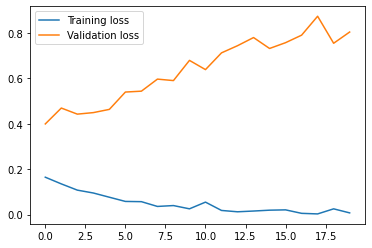

In [60]:
plt.plot(train_losses_lstm, label="Training loss")
plt.plot(valid_losses_lstm, label="Validation loss")
plt.legend()

### Prediction test

In [ ]:
from random import randrange

size = len(clean_dataset['test'])
index = randrange(size)
test_text = clean_dataset['test']['text'][index]

model_lstm.get_prediction(test_text)

> TODO: LSTM Bidirectional + 2 wrongly classified